# Chest X-Ray Abnormality Detection using Deep Learning


## Introduction
This notebook aims to develop a deep learning model to detect abnormalities in chest X-ray images. We will leverage a dataset of chest X-rays to train a convolutional neural network (CNN) to classify images into different categories, such as normal, pneumonia, or other abnormalities. The goal is to create a robust model that can assist medical professionals in diagnosing chest conditions more accurately and efficiently.

### Objective

The primary objective of this notebook is to build and evaluate a deep learning model for detecting pneumonia  in chest X-ray images. By the end of this notebook, we aim to:

- Understand the dataset and perform exploratory data analysis (EDA).
- Preprocess the images to make them suitable for model training.
- Develop a CNN model to classify chest X-ray images.
- Train the model and evaluate its performance using appropriate metrics.
- Experiment with different techniques to improve model performance, such as data augmentation and transfer learning also fine tune the model .
- Provide insights into the model's predictions and discuss potential areas for future improvement.

This project serves as an educational resource for those interested in medical image analysis and deep learning, and it demonstrates the potential of AI in healthcare applications.

## Setup :

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation,GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2,DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# Data Loading and Exploration :

## Data loading

In [2]:
# Set paths to the dataset directories (update these with your actual paths)
train_dir = '/kaggle/input/chest_xray/train'  # e.g., '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest_xray/test'    # e.g., '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

## Exploratory Data Analysis (EDA):

Displaying Normal Chest X-rays:


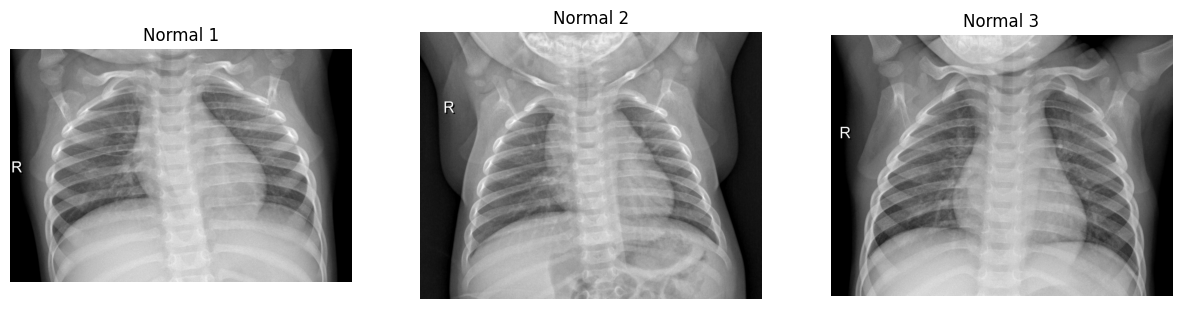

Displaying Pneumonia Chest X-rays:


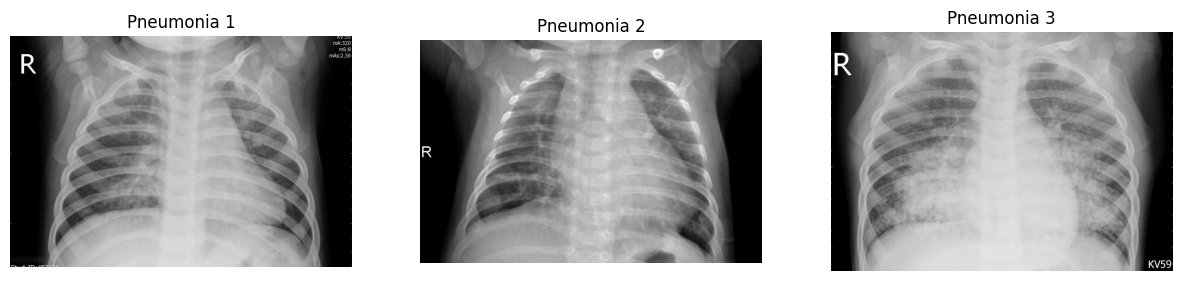

In [3]:
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Function to display images
def show_images(image_dir, label, num_images=3):
    # Get list of image files
    image_files = os.listdir(image_dir)[:num_images]  # Take first 'num_images' files
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(image_files, 1):
        img_path = os.path.join(image_dir, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img, cmap='gray')  # Assuming grayscale images; remove cmap if RGB
        plt.title(f'{label} {i}')
        plt.axis('off')
    plt.show()

# Show images from 'normal' class
print("Displaying Normal Chest X-rays:")
show_images(normal_dir, 'Normal')

# Show images from 'pneumonia' class
print("Displaying Pneumonia Chest X-rays:")
show_images(pneumonia_dir, 'Pneumonia')

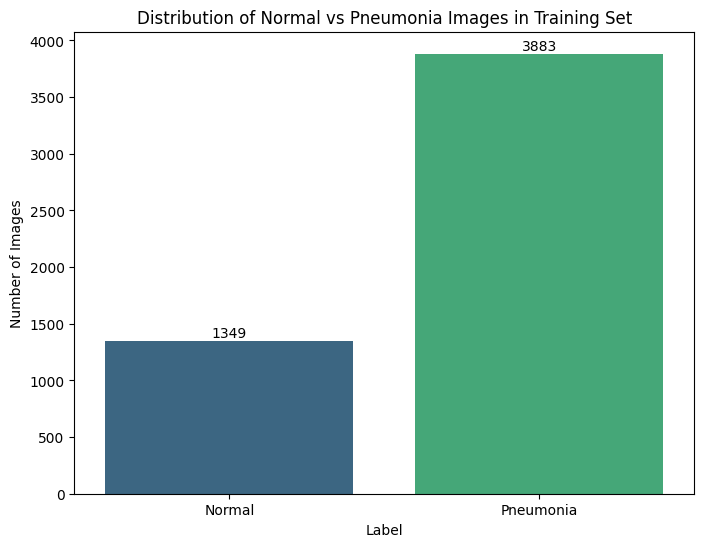

Number of Normal images: 1349
Number of Pneumonia images: 3883
Imbalance ratio (Pneumonia/Normal): 2.88


In [4]:
normal_count = len(os.listdir(normal_dir))
pneumonia_count = len(os.listdir(pneumonia_dir))

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Label': ['Normal', 'Pneumonia'],
    'Count': [normal_count, pneumonia_count]
})

# Plot the value counts
plt.figure(figsize=(8, 6))
sns.barplot(x='Label', y='Count', data=data, palette='viridis')
plt.title('Distribution of Normal vs Pneumonia Images in Training Set')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.text(0, normal_count, str(normal_count), ha='center', va='bottom')  # Add count on top of bar
plt.text(1, pneumonia_count, str(pneumonia_count), ha='center', va='bottom')  # Add count on top of bar
plt.show()

# Print the counts and imbalance ratio
print(f"Number of Normal images: {normal_count}")
print(f"Number of Pneumonia images: {pneumonia_count}")
print(f"Imbalance ratio (Pneumonia/Normal): {pneumonia_count / normal_count:.2f}")

Our data necciste data augmentation because it' s not balanced with Pneumonia : 3883 images and normal much lower with 1349 images

# Data Preprocessing

## Data Augmentation with normalization  

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,    # Randomly shift width by up to 20%
    height_shift_range=0.2,   # Randomly shift height by up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    validation_split=0.2      # Use 20% of training data for validation
)

# Only normalization for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   # Resize images to 224x224
    batch_size=32,
    class_mode='binary',      # Binary labels: 0 for normal, 1 for pneumonia
    subset='training'         # Training subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'       # Validation subset
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False             # Keep order for evaluation
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model Training

## CNN Model

In [6]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 filters, 3x3 kernel
    MaxPooling2D((2, 2)),              # Reduce spatial dimensions by half
    Conv2D(64, (3, 3), activation='relu'),  # 64 filters
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'), # 128 filters
    MaxPooling2D((2, 2)),
    Flatten(),                         # Convert to 1D vector
    Dense(512, activation='relu'),     # Fully connected layer
    Dropout(0.5),                      # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')     # Output layer for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                        # Stop after 5 epochs of no improvement
    restore_best_weights=True          # Restore best model weights
)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True                # Save only the best model
)

In [10]:
# Train the model
history1 = model.fit(
    train_generator,
    epochs=30,   
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 861ms/step - accuracy: 0.7330 - loss: 0.9118 - val_accuracy: 0.8105 - val_loss: 0.3399
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 664ms/step - accuracy: 0.8458 - loss: 0.3267 - val_accuracy: 0.8622 - val_loss: 0.2882
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 659ms/step - accuracy: 0.8576 - loss: 0.3092 - val_accuracy: 0.8785 - val_loss: 0.2685
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 660ms/step - accuracy: 0.8856 - loss: 0.2754 - val_accuracy: 0.8861 - val_loss: 0.2433
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 656ms/step - accuracy: 0.8841 - loss: 0.2673 - val_accuracy: 0.9292 - val_loss: 0.1864
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 636ms/step - accuracy: 0.9057 - loss: 0.2335 - val_accuracy: 0.9158 - val_loss: 0.2121
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 665ms/step - accuracy: 0.9051 - loss: 0.2309 - val_accuracy: 0.9330 - val_loss: 0.1702
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 641ms/step - accuracy: 0.9269 - loss: 0.1756 - va

## Transfer Learning MobileNetV2

In [11]:
# Load MobileNetV2 pre-trained on ImageNet, excluding top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),         # Reduce spatial dimensions
    Dense(512, activation='relu'),    # Fully connected layer
    Dropout(0.5),                     # Prevent overfitting
    Dense(1, activation='sigmoid')    # Binary output
])

# Compile the model
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model2.keras',
    save_best_only=True
)

In [13]:

history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 726ms/step - accuracy: 0.8508 - loss: 0.4177 - val_accuracy: 0.9244 - val_loss: 0.1728
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 638ms/step - accuracy: 0.9300 - loss: 0.1615 - val_accuracy: 0.9569 - val_loss: 0.1097
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 634ms/step - accuracy: 0.9485 - loss: 0.1303 - val_accuracy: 0.9617 - val_loss: 0.0981
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 632ms/step - accuracy: 0.9530 - loss: 0.1298 - val_accuracy: 0.9617 - val_loss: 0.1002
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 640ms/step - accuracy: 0.9536 - loss: 0.1155 - val_accuracy: 0.9627 - val_loss: 0.0931
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 637ms/step - accuracy: 0.9566 - loss: 0.1054 - val_accuracy: 0.9627 - val_loss: 0.0868
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 634ms/step - accuracy: 0.9572 - loss: 0.1212 - val_accuracy: 0.9675 - val_loss: 0.0831
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 640ms/step - accuracy: 0.9641 - loss: 

## DenseNet 121

In [14]:
# Create the base model from DenseNet121 with pre-trained ImageNet weights
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification: Normal vs Pneumonia

# Create the complete model
model3 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model3.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,562,817 (28.85 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model3.keras',
    save_best_only=True
)

In [16]:
history3 = model3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 872ms/step - accuracy: 0.7997 - loss: 0.4370 - val_accuracy: 0.9244 - val_loss: 0.1949
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 654ms/step - accuracy: 0.9185 - loss: 0.2037 - val_accuracy: 0.9292 - val_loss: 0.1755
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 650ms/step - accuracy: 0.9359 - loss: 0.1755 - val_accuracy: 0.9435 - val_loss: 0.1530
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 656ms/step - accuracy: 0.9368 - loss: 0.1617 - val_accuracy: 0.9455 - val_loss: 0.1521
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 647ms/step - accuracy: 0.9393 - loss: 0.1527 - val_accuracy: 0.9512 - val_loss: 0.1334
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 647ms/step - accuracy: 0.9491 - loss: 0.1270 - val_accuracy: 0.9512 - val_loss: 0.1376
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 653ms/step - accuracy: 0.9541 - loss: 0.1225 - val_accuracy: 0.9512 - val_loss: 0.1242
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 650ms/step - accuracy: 0.9630 - loss: 

# Evaluation

## Evaluate the CNN model

In [17]:

# Load the best model
model.load_weights('best_model.keras')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Predict on test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Threshold at 0.5
y_true = test_generator.classes

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.7500 - loss: 0.5381
Test Accuracy: 0.8494
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.64      0.76       234
   Pneumonia       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624


Confusion Matrix:
[[150  84]
 [ 10 380]]


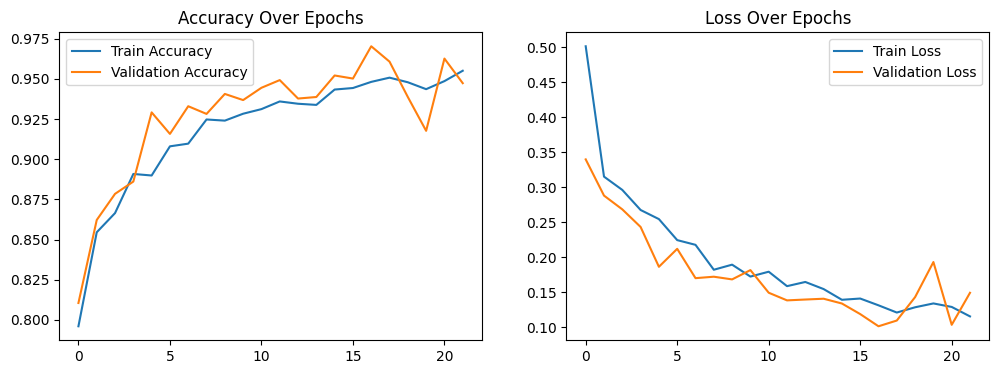

In [18]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

Input Shape: (None, 224, 224, 3)
Output Shape: (None, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicted Class: Pneumonia (Confidence: 0.9448)


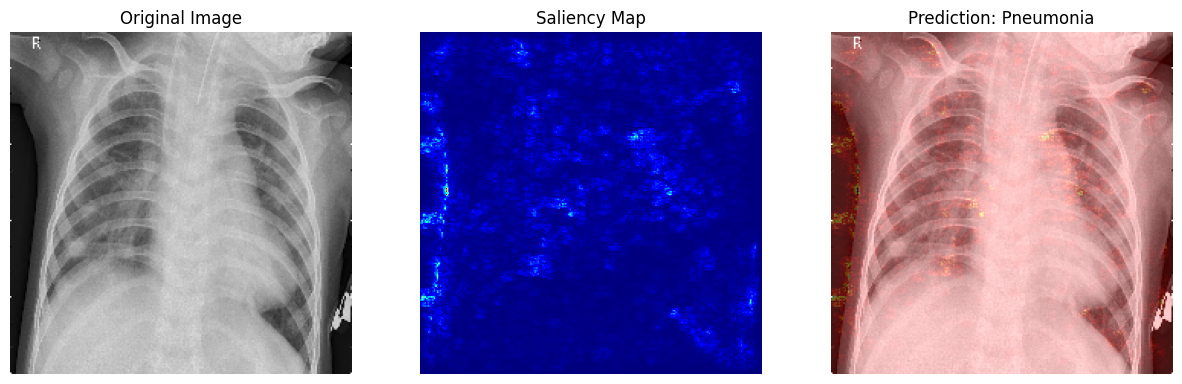

In [19]:
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)

# Define the path to a sample image
test_image_path = '/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0002.jpeg'  # Update if needed

# Load and preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Match model input size
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Get the preprocessed image
img_array = preprocess_image(test_image_path)

# Predict the class
preds = model.predict(img_array)
predicted_class = int(preds[0][0] > 0.5)  # 0 = Normal, 1 = Pneumonia
class_names = ['Normal', 'Pneumonia']
print(f"Predicted Class: {class_names[predicted_class]} (Confidence: {preds[0][0]:.4f})")

# Define a function to compute the saliency map
def compute_saliency_map(model, img_array):
    # Convert the input image to a tensor and ensure it requires gradients
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_tensor = tf.Variable(img_tensor, trainable=True)

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[:, 0]  # Use the predicted class score (sigmoid output)

    # Compute gradients of the output with respect to the input image
    grads = tape.gradient(loss, img_tensor)

    # Take the absolute value of the gradients to consider both positive and negative contributions
    saliency = tf.reduce_mean(tf.abs(grads), axis=-1)[0]  # Reduce across channels, remove batch

    # Normalize the saliency map
    saliency = saliency / (tf.reduce_max(saliency) + 1e-10)  # Avoid division by zero
    return saliency.numpy()

# Compute the saliency map
saliency_map = compute_saliency_map(model, img_array)

# Load the original image for visualization
original_img = img_to_array(load_img(test_image_path, target_size=(224, 224))) / 255.0

# Convert saliency map to RGB for overlay (optional)
saliency_colored = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
saliency_colored = np.float32(saliency_colored) / 255

# Overlay the saliency map on the original image
superimposed_img = saliency_colored * 0.4 + original_img  # Adjust transparency with 0.4

# Plot the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='jet')
plt.title('Saliency Map')
plt.axis('off')

# Superimposed Image
plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title(f'Prediction: {class_names[predicted_class]}')
plt.axis('off')

plt.show()

## Evaluate model Transfer Learning MobileNetV2

In [20]:
# Load the best model
model2.load_weights('best_model2.keras')

# Evaluate on test set
test_loss, test_acc = model2.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Predict on test set
y_pred = model2.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Threshold at 0.5
y_true = test_generator.classes

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.9085 - loss: 0.2085
Test Accuracy: 0.9359
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91       234
   Pneumonia       0.94      0.96      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624


Confusion Matrix:
[[209  25]
 [ 15 375]]


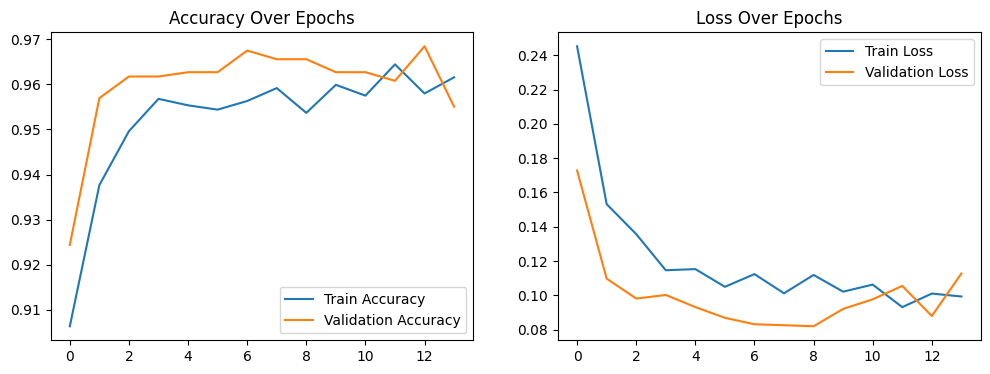

In [21]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

## Evaluate DenseNet 121

In [22]:
# Load the best model
model3.load_weights('best_model3.keras')

# Evaluate on test set
test_loss, test_acc = model3.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Predict on test set
y_pred = model3.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Threshold at 0.5
y_true = test_generator.classes

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.8309 - loss: 0.3714
Test Accuracy: 0.9022
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86       234
   Pneumonia       0.88      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624


Confusion Matrix:
[[184  50]
 [ 11 379]]


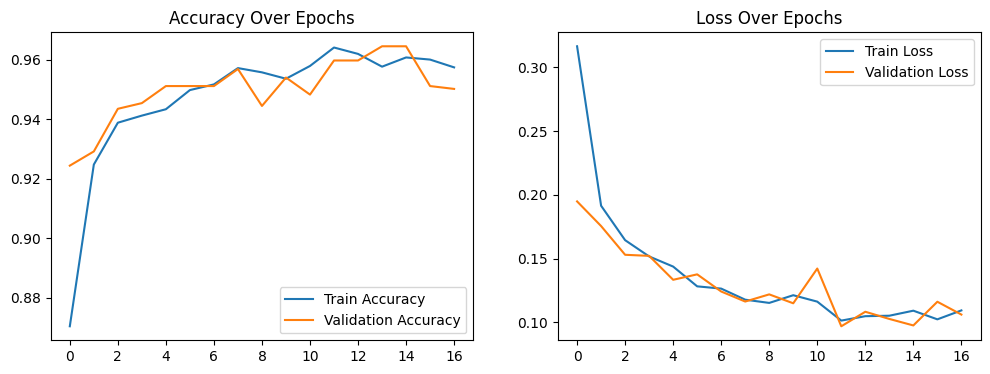

In [23]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

# Comparison between models :

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step


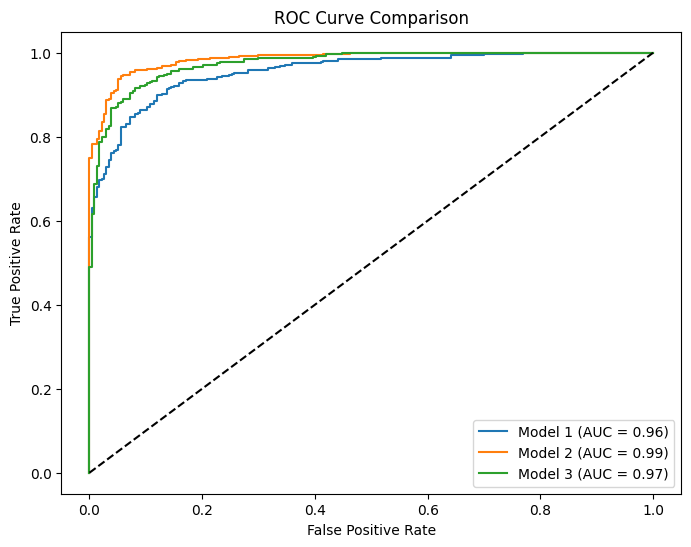

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary of already loaded models
models = {
    "Model 1": model,
    "Model 2": model2,
    "Model 3": model3
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Predict probabilities for positive class
    y_pred_probs = model.predict(test_generator)  # Use probabilities, not classes
    y_true = test_generator.classes  # True labels

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step


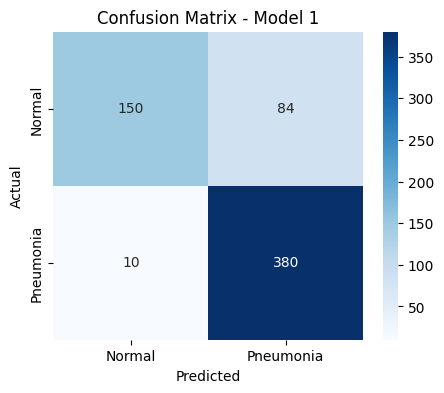

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step


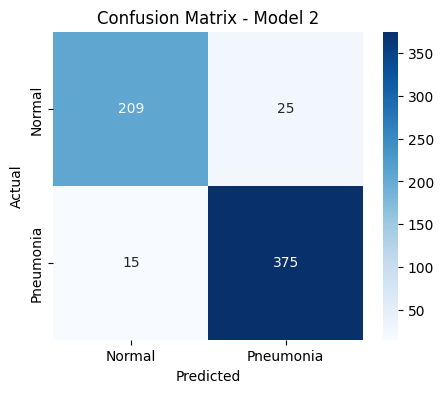

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step


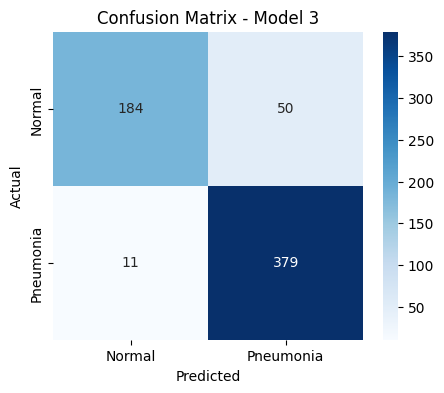

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for name, model in models.items():
    y_pred_classes = (model.predict(test_generator) > 0.5).astype(int)
    y_true = test_generator.classes  

    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### Interpretation of the ROC Curve
The ROC curve plots the **true positive rate (sensitivity)** against the **false positive rate (1-specificity)**. The closer the curve is to the **top-left corner**, the better the model performs.

#### **Model 1 (CNN from Scratch) - AUC = 0.96 (Blue Curve)**
- Built from scratch and performs fairly well with an AUC of **0.96**.
- However, compared to the transfer learning models, it has a slightly **lower AUC**.
- Suggests that the CNN has learned useful features, but it does not generalize as well as the pretrained models.

#### **Model 2 (DenseNet121) - AUC = 0.97 (Green Curve)**
- More complex architecture, known for deep connections and feature reuse.
- With an AUC of **0.97**, it performs **better than CNN** but slightly worse than MobileNetV2.
- Strong generalization but still not the best-performing model.

#### **Model 3 (MobileNetV2) - AUC = 0.99 (Orange Curve)**
- Has the **highest AUC**, meaning it has the **best ability to differentiate between normal and abnormal X-rays**.
- MobileNetV2 is a **lightweight** architecture optimized for efficiency, making it a great choice for medical applications where inference speed is crucial.
- The curve is very close to the top-left corner, indicating strong performance in distinguishing between different classes.

---

## **Confusion Matrix Analysis**
A confusion matrix helps in analyzing how well a model classifies different categories.

### **CNN (Model 1)**
- **84 false positives** (normal cases misclassified as pneumonia).
- **10 false negatives**, meaning it detects pneumonia well but struggles with normal cases.

### **DenseNet121 (Model 2)**
- Improves over CNN, reducing **false positives to 50**.
- Keeps **false negatives low (11)**.

### **MobileNetV2 (Model 3)**
- **Lowest false positives (only 25)**.
- **Slightly higher false negatives (15)** but still performs the best overall.

---

## **Accuracy Comparison**

| Model              | Accuracy |
|--------------------|----------|
| **CNN**           | 85%      |
| **DenseNet121**   | 90%      |
| **MobileNetV2**   | **94% (Best)** |

- **Transfer Learning (MobileNetV2) achieves the highest accuracy (94%)**, followed by DenseNet121 (90%), and CNN (85%).

---

## **False Positive Analysis**
- **CNN** has the highest false positives (**84 normal cases misclassified as pneumonia**).
- **DenseNet121** reduces false positives to **50**, but still more than MobileNetV2.
- **MobileNetV2** significantly reduces false positives (**only 25**) while maintaining strong recall.

---

## **Best Model: MobileNetV2**
### **Why MobileNetV2 is the Best Choice**
- **Highest AUC (0.99)** → Best at distinguishing between classes.
- **Best accuracy (94%)** → More reliable predictions.
- **Lowest false positives (25)** → Reduces misdiagnosis of normal cases.
- **Efficient and lightweight** → Ideal for real-world deployment in medical applications.

### **Final Ranking: Best to Worst**
 **1st Place: MobileNetV2** → Best performance overall (highest accuracy, AUC, lowest false positives, efficient).  
 **2nd Place: DenseNet121** → Strong, but slightly less effective than MobileNetV2.  
 **3rd Place: CNN** → Weakest model with the lowest accuracy and highest false positives.  

---

### **Conclusion:**  
**MobileNetV2 is the best choice for deployment due to its superior performance, lower false positives, and efficiency.** 
